In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from functools import partial
import optax
import pandas as pd
from utils import *

import set_rcParams

In [2]:
# Construct the dataframe
SWEEP_IDS = [
    "RESULT_OF_scans/comparison_architectures_LSI_LRU.yaml", # LRU
    "RESULT_OF_scans/comparison_architectures_LSI_RNN.yaml", # RNN
]
OG_df = pd.concat([load_sweep(id, last_step_only=True) for id in SWEEP_IDS])
OG_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Average across seeds (take mean + std)
df_comp = OG_df.groupby(["model", "d_hidden", "lr_base", "Number params", "min_nu"])[["Training loss"]].mean().reset_index()
df_comp["Training loss std"] = OG_df.groupby(["model", "d_hidden", "lr_base", "Number params", "min_nu"])[["Training loss"]].sem().reset_index()["Training loss"]

# Pick the best learning rate
df_comp = df_comp[df_comp.groupby(["model", "min_nu"])["Training loss"].transform(min) == df_comp["Training loss"]]

df_comp = df_comp.sort_values("min_nu")

SWEEP_IDS = [
    "RESULT_OF_scans/comparison_architectures_LSI_baseline.yaml"  # baseline
]
OG_df = pd.concat([load_sweep(id, last_step_only=True) for id in SWEEP_IDS])
OG_df.replace([np.inf, -np.inf], np.nan, inplace=True)
df_baseline = OG_df
df_baseline = df_baseline.sort_values("min_nu")

/tmp/ipykernel_4184769/616333563.py:14: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df_comp = df_comp[df_comp.groupby(["model", "min_nu"])["Training loss"].transform(min) == df_comp["Training loss"]]


In [3]:
# Construct the dataframe for ablation
SWEEP_IDS = [
    "RESULT_OF_scans/ablation_LRU_p1", # LRU
    "RESULT_OF_scans/ablation_LRU_p2", # RNN with 32 heads (d_hidden 64)
    "RESULT_OF_scans/ablation_LRU_p3", # RNN with 64 heads (d_hidden 128)
]
OG_df = pd.concat([load_sweep(id, last_step_only=True) for id in SWEEP_IDS])
OG_df.replace([np.inf, -np.inf], np.nan, inplace=True)

df_ablation = OG_df.groupby(["model", "lru_which_gamma", "lru_param", "lr_base", "rnn_n_heads"])[["Training loss"]].mean().reset_index()
df_ablation["Training loss std"] = OG_df.groupby(["model", "lru_which_gamma", "lru_param", "lr_base", "rnn_n_heads"])[["Training loss"]].sem().reset_index()["Training loss"]

# Pick the best learning rate
df_ablation = df_ablation[df_ablation.groupby(["model", "lru_which_gamma", "lru_param", "rnn_n_heads"])["Training loss"].transform(min) == df_ablation["Training loss"]]

data_ablation = [
    df_comp[(df_comp["model"] == "RNN") & (df_comp["min_nu"] == 0.99)],
    df_ablation[(df_ablation["model"] == "RNN") & (df_ablation["rnn_n_heads"] == 32)],
    df_ablation[(df_ablation["model"] == "RNN") & (df_ablation["rnn_n_heads"] == 64)],
    df_ablation[(df_ablation["model"] == "LRU") & (df_ablation["lru_which_gamma"] == "none") & (df_ablation["lru_param"] == "default")],
    df_ablation[(df_ablation["model"] == "LRU") & (df_ablation["lru_which_gamma"] == "learned") & (df_ablation["lru_param"] == "default")],
    df_ablation[(df_ablation["model"] == "LRU") & (df_ablation["lru_which_gamma"] == "learned") & (df_ablation["lru_param"] == "exp")],
]

/tmp/ipykernel_4184769/626620654.py:14: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df_ablation = df_ablation[df_ablation.groupby(["model", "lru_which_gamma", "lru_param", "rnn_n_heads"])["Training loss"].transform(min) == df_ablation["Training loss"]]


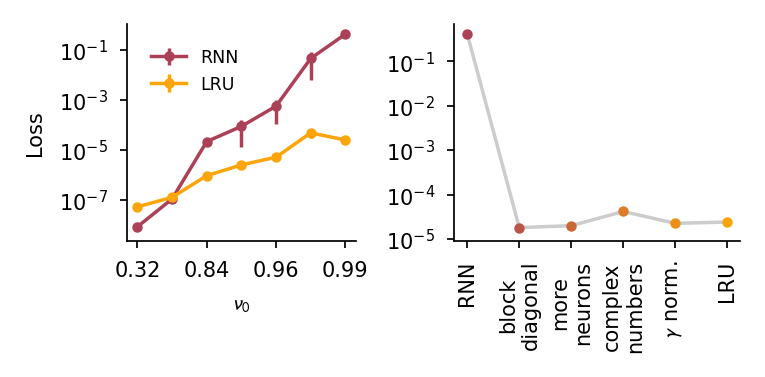

In [4]:
COLORS_RED = [
    "#AC4056",
    "#bc5447",
    "#cc6837",
    "#dc7c28",
    "#ec9019",
    "#FCA50A",
]

colors = {
    "RNN": COLORS_RED[0],
    "LRU": COLORS_RED[-1],
}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(3., 1.45), gridspec_kw={"width_ratios": [1, 1.25]})

for i, model in enumerate(["RNN", "LRU"]):
    data = df_comp[(df_comp["model"] == model)]
    ax[0].errorbar(6 - np.log2((1 - data["min_nu"])*100), data["Training loss"], yerr=data["Training loss std"], fmt="o", markersize=2, color=colors[model], linestyle="-", linewidth=1, label=model)
ax[0].legend( borderaxespad=1, edgecolor="white", fontsize=5, framealpha=1)
# ax[0].plot(6 - np.log2((1 - df_baseline["min_nu"])*100), df_baseline["Training loss"], linestyle="-", linewidth=1, color = "#CCCCCC")

ax[0].set_ylabel("Loss")
ax[0].set_xlabel(r"$\nu_0$")
ax[0].set_yscale("log")
ax[0].set_xticks([0, 2, 4, 6], [0.32, 0.84, 0.96, 0.99])

plt.plot(np.arange(len(data_ablation)), [d["Training loss"].item() for d in data_ablation], linestyle="-", linewidth=1, color = "#CCCCCC")
for i, d in enumerate(data_ablation):
    ax[1].errorbar(i, d["Training loss"].item(), yerr=d["Training loss std"].item(), fmt="o", markersize=2, color=COLORS_RED[i])
ax[1].set_yscale("log")
# ax[1].set_ylabel("Loss")
ax[1].minorticks_off()

ticks = [
    "RNN",
    "block\ndiagonal",
    "more\nneurons",
    "complex\nnumbers",
    "$\gamma$ norm.",
    "LRU"
]
ax[1].set_xticks(np.arange(len(data_ablation)), ticks, rotation=90, ha="center")

plt.tight_layout(pad=0.5)